In [1]:
!echo $PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib ipympl

NEURONS_FILE = "basal_ganglia_neurons.yaml"
NETWORK_FILE = "basal_ganglia_network.yaml"
DOPAMINE_FILE = "basal_ganglia_dopamine_susceptibility.yaml"

# FSN [1020] Hz ([55, 62]), D1 and D2 (MSN) [0.5–2.5] Hz ([63]), GPe-TI [40–60] Hz ([45]), GPe-TA [5–15] Hz ([45]) and STN [12–20] Hz ([24]).

/home/dianloo/Desktop/tesi/quilt


## Parameters of the simulation

In [2]:
Tlong = 8000  # ms
dt = 0.1 # ms

points_per_bin = 1/dt     # bins 1 ms wide
sampling_frequency = 1e3  # 1 kHz sampling frequency
burn_in_millis = 600      # the first part of the record to discard (ms)

# Params for trials
n_trials = 10
Tshort = 1500 # ms

## Utils & plots

In [3]:
from scipy.signal import butter, sosfiltfilt, freqz, welch
from scipy.integrate import simpson
from scipy.stats import entropy

def bin_spikes(spikes, points_per_bin = 10):
    binned_signal = np.sum( spikes[:(len(spikes)//points_per_bin)*points_per_bin].reshape(-1, points_per_bin),
                        axis=1).squeeze()
    return binned_signal

def beta_power(sn, population):    
    spikes = sn.populations[population].get_data()['spikes']
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    T = len(binned_spikes)
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = T/2, # Takes at least 3 windows
                   noverlap= T/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    print(f"f peak {f[np.argmax(PSD)]}")
    beta_mask = (f>12)&(f<30)
    return np.trapz(PSD[beta_mask], x=f[beta_mask])

def bandpass(data, edges, sample_rate, poles = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

In [4]:
def plot_spectrum(sn, scale="log"):
    fig, axes = plt.subplots(len(sn.populations), 1, sharex=True)
    for ax, pop in zip(axes, sn.populations):
        spikes = sn.populations[pop].get_data()['spikes']
        binned_spikes = bin_spikes(spikes)
        binned_spikes = binned_spikes[burn_in_millis:]
        T = len(binned_spikes)
        print(f"Mean firing rate {pop} is {np.sum(spikes)/sn.populations[pop].n_neurons/(Tlong/1000) :.1f} Hz")
        f, PSD = welch(binned_spikes, 
                       sampling_frequency, 
                       nperseg=T/2, 
                       noverlap=T/4,
                       nfft=None, 
                       scaling='density', 
                       window='hamming')
    
        norm = simpson(PSD, x=f)
        ax.plot(f, PSD/norm, label=pop)
        
        ax.set_ylabel(pop)
        ax.set_yscale(scale)
    print(f"F resolution { f[1] - f[0] :.2f} Hz")
    # plt.yscale('log')
    # plt.legend()
    # plt.ylabel("normalized PSD")
    plt.xlabel("Frequency [Hz]")
    plt.xlim(0,150)
    fig.set_figheight(10)
    
def plot_signals(sn):
    fig, axes = plt.subplots(len(sn.populations), 1, sharex=True)
    for ax, pop in zip(axes, sn.populations):
        binned_spikes = bin_spikes(sn.populations[pop].get_data()['spikes'])
        instantaneous_fr = binned_spikes/sn.populations[pop].n_neurons*1000
        
        tt = np.linspace(0, len(instantaneous_fr)/1000, len(instantaneous_fr))
        ax.plot(tt, instantaneous_fr)
        ax.plot(tt, bandpass(instantaneous_fr, [12, 24], 1000), label="beta")
        ax.plot(tt, bandpass(instantaneous_fr, [30, 140], 1000), label="gamma")
        ax.set_ylabel(pop)
    # ax.set_xlim(1.5, 2)
    fig.suptitle("Instantaneous firing rate [Hz]")
    ax.set_xlabel("time [s]")
    fig.set_figheight(10)

## Building the network

In [5]:
from quilt.interface.spiking import set_verbosity
set_verbosity(1)

In [6]:
from quilt.builder import NeuronCatalogue, ParametricSpikingNetwork

neuron_catalogue = NeuronCatalogue.from_yaml(NEURONS_FILE)
sn = ParametricSpikingNetwork.from_yaml(NETWORK_FILE, 
                                        DOPAMINE_FILE, 
                                        neuron_catalogue)

sn.set_parameters(dopamine=0.9)
sn.build()

Building parametric network with params {'dopamine': 0.9}

Output()

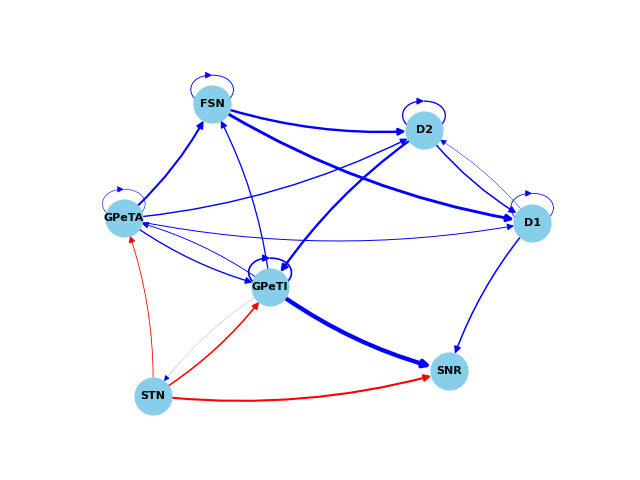

In [7]:
from quilt.view import plot_graph
fig, ax = plt.subplots()
plot_graph(sn)
plt.show()

## Input/Output

In [8]:
for population in sn.populations.values():
    population.monitorize_spikes()

In [9]:
Dd = 1.0
poisson_inputs = dict(D1    = [1120 * Dd, 0.45],
                      D2    = [973 * Dd, 0.45],
                      STN   = [500, 0.25],
                      GPeTA = [170, 0.15],
                      GPeTI = [1530, 0.25 ],
                      FSN   = [944.4, 0.5],
                      SNR   = [6000, 0.55]
                    )
for pop in poisson_inputs:
    sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])

## Control case (Healty subject)

In [10]:
sn.run(dt=dt, time=Tlong)

Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 150 s	(1.87975 ms/step)
	Gathering time avg: 0.182338 us/step
	Inject time avg: 206.354 us/step
Population evolution stats:
	0:
		evolution:	520.182 us/step	---	86 ns/step/neuron
		spike emission:	48.751 us/step	---	8 ns/step/neuron
	1:
		evolution:	501.101 us/step	---	83 ns/step/neuron
		spike emission:	63.9597 us/step	---	10 ns/step/neuron
	2:
		evolution:	92.1959 us/step	---	219 ns/step/neuron
		spike emission:	12.7334 us/step	---	30 ns/step/neuron
	3:
		evolution:	122.251 us/step	---	156 ns/step/neuron
		spike emission:	22.3452 us/step	---	28 ns/step/neuron
	4:
		evolution:	66.6548 us/step	---	256 ns/step/neuron
		spike emission:	5.29593 us/step	---	20 ns/step/neuron
	5:
		evolution:	78.4206 us/step	---	192 ns/step/neuron
		spike emission:	5.13448 us/step	---	12 ns/step/neuron
	6:
		evolution:	120.625 u

In [11]:
spikes = dict()
for pop in sn.populations.keys():
    spikes[pop] = sn.populations[pop].get_data()['spikes']

Mean firing rate D1 is 0.9 Hz
Mean firing rate D2 is 1.5 Hz
Mean firing rate FSN is 16.2 Hz
Mean firing rate GPeTI is 62.8 Hz
Mean firing rate GPeTA is 8.2 Hz
Mean firing rate STN is 13.8 Hz
Mean firing rate SNR is 16.1 Hz
F resolution 0.27 Hz


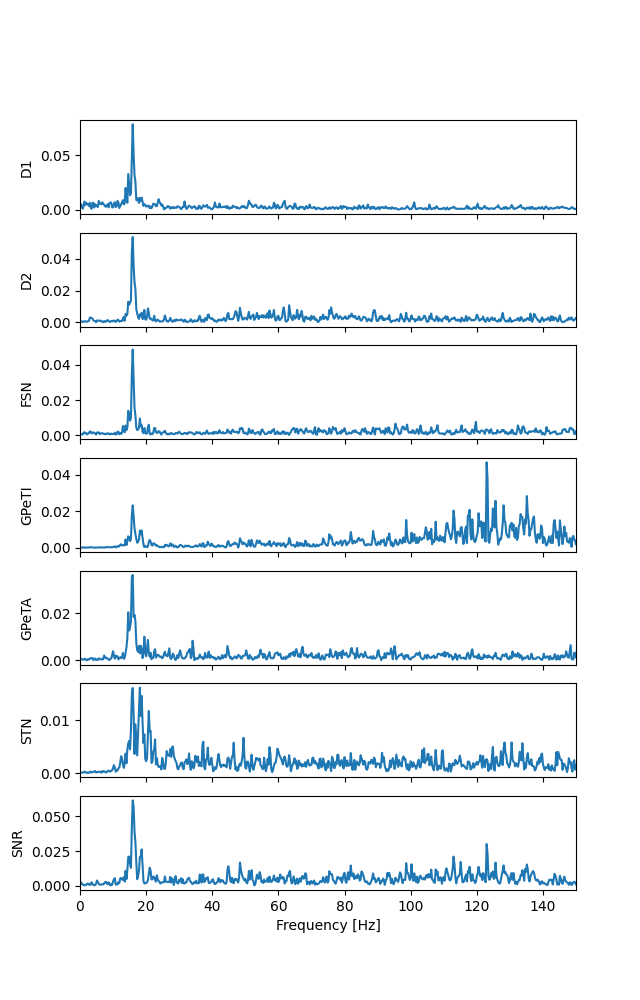

In [12]:
# print(beta_power(sn, "GPeTA"))
plot_spectrum(sn, scale="linear")

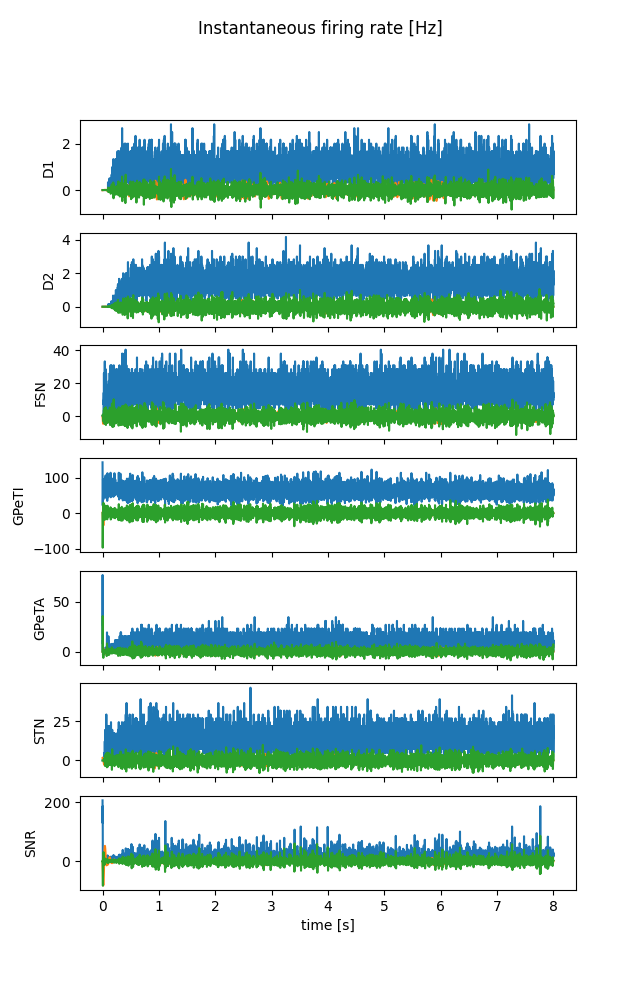

In [13]:
plot_signals(sn)

## Lesioned case (PD)

In [14]:
sn = ParametricSpikingNetwork.from_yaml(NETWORK_FILE, 
                                        DOPAMINE_FILE, 
                                        neuron_catalogue)
sn.set_parameters(dopamine=0)
sn.build()

for population in sn.populations.values():
    population.monitorize_spikes()
Dd = 1.0
poisson_inputs = dict(D1    = [1120 * Dd, 0.45],
                      D2    = [973 * Dd, 0.45],
                      STN   = [500, 0.25],
                      GPeTA = [170, 0.15],
                      GPeTI = [1530, 0.25 ],
                      FSN   = [944.4, 0.5],
                      SNR   = [6000, 0.55]
                    )
for pop in poisson_inputs:
    sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    
sn.run(dt=dt, time=Tlong)

Building parametric network with params {'dopamine': 0}

Output()

Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 149 s	(1.87359 ms/step)
	Gathering time avg: 0.150537 us/step
	Inject time avg: 208.67 us/step
Population evolution stats:
	0:
		evolution:	526.99 us/step	---	87 ns/step/neuron
		spike emission:	65.2455 us/step	---	10 ns/step/neuron
	1:
		evolution:	489.648 us/step	---	81 ns/step/neuron
		spike emission:	53.4076 us/step	---	8 ns/step/neuron
	2:
		evolution:	90.5313 us/step	---	215 ns/step/neuron
		spike emission:	13.8983 us/step	---	33 ns/step/neuron
	3:
		evolution:	120.717 us/step	---	154 ns/step/neuron
		spike emission:	16.6653 us/step	---	21 ns/step/neuron
	4:
		evolution:	66.4908 us/step	---	255 ns/step/neuron
		spike emission:	5.90915 us/step	---	22 ns/step/neuron
	5:
		evolution:	76.0524 us/step	---	186 ns/step/neuron
		spike emission:	6.15941 us/step	---	15 ns/step/neuron
	6:
		evolution:	118.954 us

Mean firing rate D1 is 6.2 Hz
Mean firing rate D2 is 2.1 Hz
Mean firing rate FSN is 12.6 Hz
Mean firing rate GPeTI is 43.5 Hz
Mean firing rate GPeTA is 8.7 Hz
Mean firing rate STN is 16.9 Hz
Mean firing rate SNR is 175.2 Hz
F resolution 0.27 Hz


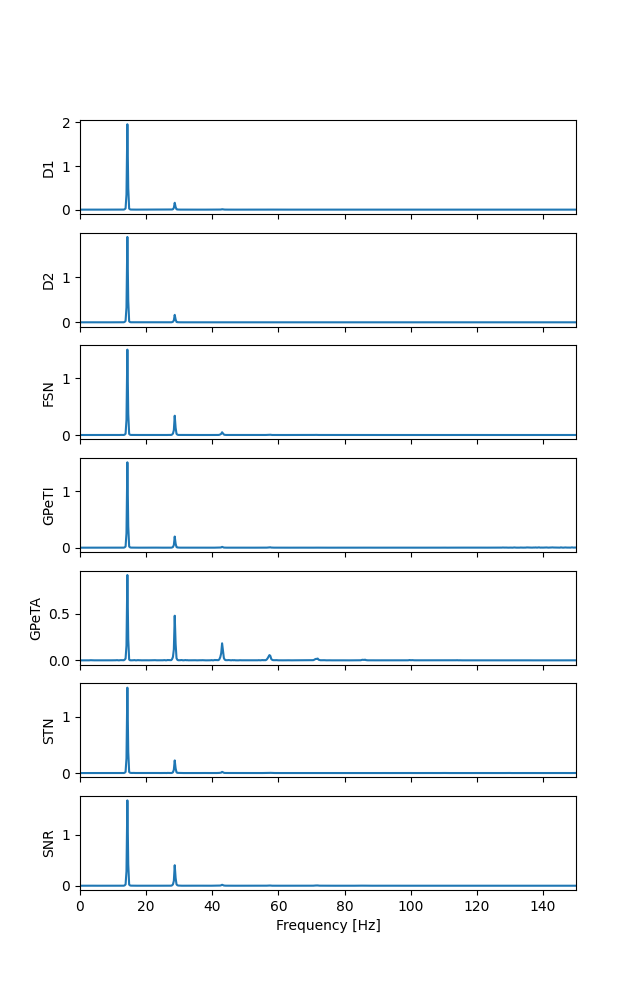

In [15]:
plot_spectrum(sn, scale="linear")

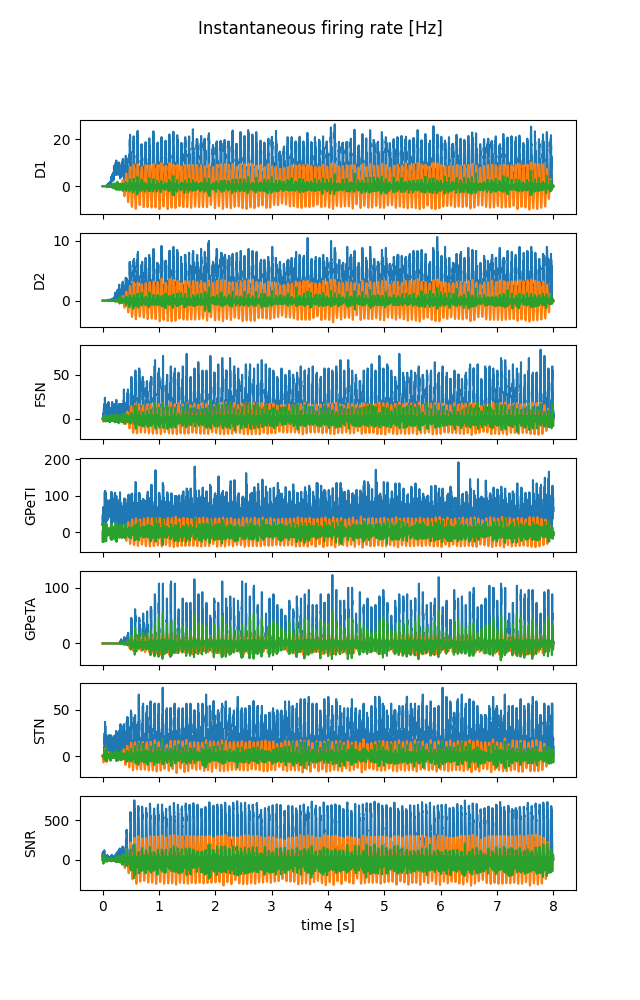

In [16]:
plot_signals(sn)

## Tuning
Starts an optuna study to tune `poisson_rescale` and `weight_rescale`. As objective function the total beta-range power is chosen.

In [17]:
import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

In [18]:
def build_network(poisson_rescale, rescale_weights):
    global neuron_catalogue
    sn = SpikingNetwork.from_yaml(NETWORK_FILE, neuron_catalogue)

    # sn.rescale_populations(0.2)
    # sn.rescale_connectivity(1)
    sn.rescale_weights(rescale_weights)
    # sn.rescale_delays(1)
    
    sn.build()

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [6000, 0.55],
                          D1    = [1120, 0.45],
                          D2    = [972.972, 0.45]
                        )
    # poisson_rescale = 0.8
    for pi in poisson_inputs.values():
        pi[1] *= poisson_rescale
        
    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    
    return sn
    
def optimize_beta_power(trial):
    sn = build_network(trial.suggest_float("poisson_rescale", 0.1 , 2 ),
                       trial.suggest_float("weight_rescale", 0.1, 2))
    sn.run(dt=0.1, time=Tshort)
    return beta_power(sn, "GPeTA")

In [19]:
set_verbosity(0) # Turns off C++ outputs

study_power = optuna.create_study(direction = 'maximize')
study_power.optimize(optimize_beta_power, n_trials = n_trials, n_jobs = 3, catch=(ValueError, TypeError))

[I 2024-02-03 01:08:35,918] A new study created in memory with name: no-name-0021beda-58c0-431f-859d-ece827ce035b
[W 2024-02-03 01:08:35,989] Trial 0 failed with parameters: {'poisson_rescale': 1.0079423469655477, 'weight_rescale': 0.7236486592708185} because of the following error: NameError("name 'SpikingNetwork' is not defined").
Traceback (most recent call last):
  File "/home/dianloo/Desktop/tesi/quilt/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_3468307/3057679120.py", line 33, in optimize_beta_power
    sn = build_network(trial.suggest_float("poisson_rescale", 0.1 , 2 ),
  File "/tmp/ipykernel_3468307/3057679120.py", line 3, in build_network
    sn = SpikingNetwork.from_yaml(NETWORK_FILE, neuron_catalogue)
NameError: name 'SpikingNetwork' is not defined
[W 2024-02-03 01:08:35,990] Trial 1 failed with parameters: {'poisson_rescale': 0.9352715577784537, 'weight_rescale': 0.51620204373

NameError: name 'SpikingNetwork' is not defined

In [ ]:
x = []
y = []
z = []
for trial in study_power.trials:
    x += [trial.params['poisson_rescale']]
    y += [trial.params['weight_rescale']]
    z += [trial.value]

fig, ax = plt.subplots()
plt.scatter(x, y, c=z)
plt.colorbar()
plt.scatter(study_power.best_params['poisson_rescale'],study_power.best_params['weight_rescale'], marker="x", color="r")
plt.xlabel("Poisson weight global factor [a.u.]")
plt.ylabel("Internal weight global factor [a.u.]")
plt.title("Integrated beta power")

plt.show()

## Plot best params

In [ ]:
set_verbosity(1)
best_params = study_power.best_params

print(best_params)
print(study_power.best_value)

sn = build_network(best_params['poisson_rescale'], best_params['weight_rescale'])
sn.run(dt=dt, time=Tlong)

In [ ]:
plot_spectrum(sn, scale="log")

## Time signal analysis

In [ ]:
plot_signals(sn)

## Spectral entropy

In [ ]:
from scipy.stats import entropy

def build_network(D1_freq = 1120, D2_freq = 972.972):
    global neuron_catalogue    
    sn = SpikingNetwork.from_yaml(NETWORK_FILE, neuron_catalogue)

    sn.build(progress_bar=False)

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [6000, 0.55],
                          D1    = [D1_freq, 0.45],
                          D2    = [D2_freq, 0.45]
                        )

    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    return sn

def optimize_spectral_entropy(trial):
    sn = build_network(trial.suggest_float("D1_freq", 800, 1200),
                       trial.suggest_float("D2_freq", 800, 1200)
                      )    
    sn.run(dt=0.1, time=Tshort)
    return spectral_entropy(sn, "D1")

In [ ]:
set_verbosity(0) 

study_entropy = optuna.create_study(direction = 'minimize')
study_entropy.optimize(optimize_spectral_entropy, n_trials = 30, n_jobs = 3, catch=(ValueError, TypeError))

In [ ]:
x = []
y = []
z = []
for trial in study_entropy.trials:
    x += [trial.params['D1_freq']]
    y += [trial.params['D2_freq']]
    z += [trial.value]

fig, ax = plt.subplots()

plt.scatter(x, y, c=z)
plt.colorbar()
plt.scatter(study_entropy.best_params['D1_freq'],study_entropy.best_params['D2_freq'], marker="x", color="r")

plt.xlabel("D1 poisson rate [Hz]")
plt.ylabel("D2 poisson rate [Hz]")
plt.title("Spectral entropy of D1")
plt.show()

In [ ]:
set_verbosity(1)
best_params = study_entropy.best_params

print(best_params)
print(study_entropy.best_value)

sn = build_network(**best_params)
# sn = build_network(D1_freq=best_params['D1_freq'], D2_freq=best_params['D2_freq'])
sn.run(dt=dt, time=Tlong)

In [ ]:
plot_spectrum(sn)

In [ ]:
plot_signals(sn)

## More parameters

In [ ]:
from scipy.stats import entropy

def build_network(D1_freq = 1120, D2_freq = 972.972, D1_weight=0.45, D2_weight=0.45, 
                    FSNtoD1_w=6.6, FSNtoD2_w=4.8, 
                    weight_delta=0, delay_delta=0.0, run_time=Tshort):
    
    global neuron_catalogue
    sn = SpikingNetwork.from_yaml(NETWORK_FILE, neuron_catalogue)

    # sn.rescale_populations(0.1)
    # sn.rescale_connectivity(1)
    sn.rescale_weights(1.17)
    # sn.rescale_delays(1)
    for projection in sn.features_dict['projections']:
        projection['features']['weight_delta'] = weight_delta
        # projection['features']['delay_delta'] = delay_delta
        if projection['name'] == "FSN->D1":
            projection['features']['weight'] = FSNtoD1_w
        if projection['name'] == "FSN->D2":
            projection['features']['weight'] = FSNtoD2_w
        
    sn.build(progress_bar=False)

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [6000, 0.55],
                          D1    = [D1_freq, D1_weight],
                          D2    = [D2_freq, D2_weight]
                        )
    
    poisson_rescale = 1.85
    for pi in poisson_inputs.values():
        pi[1] *= poisson_rescale
        
    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    return sn

def optimize_spectral_entropy_2(trial):

    params_intervals = dict(D1_freq = [1000,1300], D2_freq = [800, 1100], D1_weight=[0.35, 0.55], D2_weight=[0.35, 0.55], 
                    FSNtoD1_w=[5.6, 7.6], FSNtoD2_w=[3.8, 5.8], 
                    weight_delta=[0, 1], delay_delta=[0,0.5])
    
    params_suggestions = dict()
    for param_name in params_intervals.keys():
        params_suggestions[param_name] = trial.suggest_float(param_name, *(params_intervals[param_name]))
    # params_default = dict(D1_freq = 1120, D2_freq = 972.972, D1_weight=0.45, D2_weight=0.45, 
    #                 FSNtoD1_w=6.6, FSNtoD2_w=4.8, 
    #                 weight_delta=0, delay_delta=0.0)
    sn = build_network(**params_suggestions)
    time = trial.suggest_int(run_time, Tshort/3, Tshort)
    sn.run(dt=0.1, time=Tshort)
    return spectral_entropy(sn, "D1")

In [ ]:
set_verbosity(0) 

study_entropy2 = optuna.create_study(direction = 'minimize', study_name="entropy2")
study_entropy2.optimize(optimize_spectral_entropy_2, n_trials = n_trials, n_jobs = 3, catch=(RuntimeError))

In [ ]:
results_df = study_entropy2.trials_dataframe()
results_df.to_csv('entropy2_eeee.csv', index=False)

In [ ]:
set_verbosity(1)
best_params = study_entropy2.best_params

print(best_params)
print(study_entropy2.best_value)
sn = build_network(**best_params)

sn.run(dt=dt, time=Tlong)

In [ ]:
plot_spectrum(sn)
plot_signals(sn)